In [1]:
#importing needed libraries
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

In [2]:
#Loading counties related data
data = pd.read_csv('us-counties.csv')
data.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [3]:
#Only NY Data - for cases and deaths
data_ny = data[data['state']=='New York']
data_ny.shape

(3117, 6)

In [4]:
#Aggregating over counties of NY
data_grouped = data_ny.groupby(['county','fips']).sum()
data_grouped.reset_index(level=0, inplace=True)
data_grouped.head()

,county,cases,deaths
fips,,,
36001.0,Albany,31733,1469
36003.0,Allegany,1142,7
36007.0,Broome,8051,443
36009.0,Cattaraugus,1355,15
36011.0,Cayuga,1367,34


In [5]:
#Loading spatial data on counties acquired from the following link - https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2019&layergroup=Counties+%28and+equivalent%29
spatial_data = gpd.read_file('tl_2019_us_county.shp')
spatial_data.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


In [6]:
#Making necessary conversions to ease joins
data_grouped.index=data_grouped.index.astype(int)
spatial_data.GEOID = spatial_data.GEOID.astype(int)

In [7]:
#Joining spatial data with case data
sdat = pd.merge(spatial_data,data_grouped,how='inner',left_on=spatial_data.GEOID,right_on=data_grouped.index)
sdat = sdat.drop(columns=['key_0'])
sdat = sdat[sdat['county'].notna()]
sdat.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,county,cases,deaths
0,36,101,00974148,36101,Steuben,Steuben County,06,H1,G4020,236,...,None,A,3601520291,35040141,+42.2667252,-077.3855253,"POLYGON ((-77.42309 42.57664, -77.42237 42.576...",Steuben,6217,293
1,36,091,00974143,36091,Saratoga,Saratoga County,06,H1,G4020,104,...,None,A,2097879145,87573063,+43.1061353,-073.8553872,"POLYGON ((-74.12434 43.15390, -74.12457 43.155...",Saratoga,11112,79
2,36,003,00974100,36003,Allegany,Allegany County,06,H1,G4020,None,...,None,A,2666029673,12999275,+42.2478532,-078.0261531,"POLYGON ((-78.30919 42.26113, -78.30920 42.271...",Allegany,1142,7
3,36,075,00974136,36075,Oswego,Oswego County,06,H1,G4020,532,...,None,A,2464751381,933476015,+43.4614431,-076.2092618,"POLYGON ((-76.61759 43.42388, -76.62522 43.500...",Oswego,1972,14
4,36,111,00974153,36111,Ulster,Ulster County,06,H1,G4020,408,...,None,A,2911757960,94596776,+41.9472124,-074.2654582,"POLYGON ((-74.67402 41.97167, -74.68567 41.976...",Ulster,35518,260


In [8]:
#Getting centroid values and removing data for Alaska
sdat["x"] = sdat.centroid.map(lambda p: p.x)
sdat["y"] = sdat.centroid.map(lambda p: p.y)
sdat = sdat[sdat['x'] > -130]
sdat.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,county,cases,deaths,x,y
0,36,101,00974148,36101,Steuben,Steuben County,06,H1,G4020,236,...,3601520291,35040141,+42.2667252,-077.3855253,"POLYGON ((-77.42309 42.57664, -77.42237 42.576...",Steuben,6217,293,-77.383803,42.267809
1,36,091,00974143,36091,Saratoga,Saratoga County,06,H1,G4020,104,...,2097879145,87573063,+43.1061353,-073.8553872,"POLYGON ((-74.12434 43.15390, -74.12457 43.155...",Saratoga,11112,79,-73.863905,43.107381
2,36,003,00974100,36003,Allegany,Allegany County,06,H1,G4020,None,...,2666029673,12999275,+42.2478532,-078.0261531,"POLYGON ((-78.30919 42.26113, -78.30920 42.271...",Allegany,1142,7,-78.027561,42.257391
3,36,075,00974136,36075,Oswego,Oswego County,06,H1,G4020,532,...,2464751381,933476015,+43.4614431,-076.2092618,"POLYGON ((-76.61759 43.42388, -76.62522 43.500...",Oswego,1972,14,-76.208687,43.463883
4,36,111,00974153,36111,Ulster,Ulster County,06,H1,G4020,408,...,2911757960,94596776,+41.9472124,-074.2654582,"POLYGON ((-74.67402 41.97167, -74.68567 41.976...",Ulster,35518,260,-74.258570,41.888146


In [9]:
#Loading demographic data
dem_data = pd.read_excel('Countylevel_ACS_data_NY&CA.xlsx')
dem_data.head()

,geo_id,total_pop,male_pop,female_pop,median_age,white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,...,no_cars,pop_determined_poverty_status,poverty,gini_index,county_name,state_fips_code,county_fips_code,legal_area_code,area_land_meters,area_water_meters
0,6091,2885,1488,1397,55.0,2509,4,0,290,28,...,66,2858,351,0.4824,Sierra,6,91,6,2468694586,23299110
1,6003,1203,664,539,44.9,777,18,8,117,248,...,16,1188,235,0.4981,Alpine,6,3,6,1912292631,12557304
2,6049,9017,4659,4358,47.8,7035,65,96,1317,361,...,146,8728,1584,0.4354,Modoc,6,49,6,10140960164,745420669
3,6043,17658,8863,8795,51.1,14309,215,168,1870,416,...,239,17456,2629,0.4492,Mariposa,6,43,6,3752472156,36225644
4,36017,48763,24382,24381,44.4,46262,418,208,1048,145,...,1567,47964,6973,0.4239,Chenango,36,17,6,2314378336,13062477


In [10]:
#Looking at data types
dem_data.columns

Index(['geo_id', 'total_pop', 'male_pop', 'female_pop', 'median_age',
       'white_pop', 'black_pop', 'asian_pop', 'hispanic_pop', 'amerindian_pop',
       'other_race_pop', 'two_or_more_races_pop', 'not_hispanic_pop',
       'commuters_by_public_transportation', 'households', 'median_income',
       'income_per_capita', 'housing_units', 'median_rent',
       'percent_income_spent_on_rent', 'commuters_16_over',
       'commute_less_10_mins', 'commute_35_44_mins', 'commute_60_more_mins',
       'commute_10_14_mins', 'commute_15_19_mins', 'commute_20_24_mins',
       'commute_25_29_mins', 'commute_30_34_mins', 'commute_45_59_mins',
       'commute_60_89_mins', 'commute_90_more_mins',
       'aggregate_travel_time_to_work', 'income_less_10000',
       'income_10000_14999', 'income_15000_19999', 'income_20000_24999',
       'income_25000_29999', 'income_30000_34999', 'income_35000_39999',
       'income_40000_44999', 'income_45000_49999', 'income_50000_59999',
       'income_60000_74999',

In [11]:
#Subsetting few columns
dem_data_sub = dem_data[['geo_id','median_income','commute_45_59_mins','gini_index','commuters_by_subway_or_elevated',
                        'county_name']]
dem_data_sub.head()

,geo_id,median_income,commute_45_59_mins,gini_index,commuters_by_subway_or_elevated,county_name
0,6091,44190,179,0.4824,0,Sierra
1,6003,63438,44,0.4981,0,Alpine
2,6049,39296,154,0.4354,0,Modoc
3,6043,51385,551,0.4492,0,Mariposa
4,36017,48567,1195,0.4239,14,Chenango


In [12]:
#Mergining demographic data
ddat = pd.merge(sdat,dem_data_sub,how='inner',left_on=sdat.NAME,right_on=dem_data_sub.county_name)
ddat = ddat.drop(columns=['key_0'])
ddat.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,cases,deaths,x,y,geo_id,median_income,commute_45_59_mins,gini_index,commuters_by_subway_or_elevated,county_name
0,36,101,00974148,36101,Steuben,Steuben County,06,H1,G4020,236,...,6217,293,-77.383803,42.267809,36101,50157,2328,0.4531,2,Steuben
1,36,091,00974143,36091,Saratoga,Saratoga County,06,H1,G4020,104,...,11112,79,-73.863905,43.107381,36091,77548,9044,0.4183,78,Saratoga
2,36,003,00974100,36003,Allegany,Allegany County,06,H1,G4020,None,...,1142,7,-78.027561,42.257391,36003,45359,1018,0.4169,9,Allegany
3,36,075,00974136,36075,Oswego,Oswego County,06,H1,G4020,532,...,1972,14,-76.208687,43.463883,36075,51755,4479,0.4279,5,Oswego
4,36,111,00974153,36111,Ulster,Ulster County,06,H1,G4020,408,...,35518,260,-74.258570,41.888146,36111,61652,6765,0.4553,522,Ulster


In [13]:
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

In [14]:
y = ddat['cases'].values
x = ddat['median_income'].values
w = Queen.from_dataframe(ddat)

In [15]:
moran = Moran(y,w)
moran_bv = Moran_BV(y, x, w)
moran_loc = Moran_Local(y, w)
moran_loc_bv = Moran_Local_BV(y, x, w)

NameError: name 'Moran' is not defined

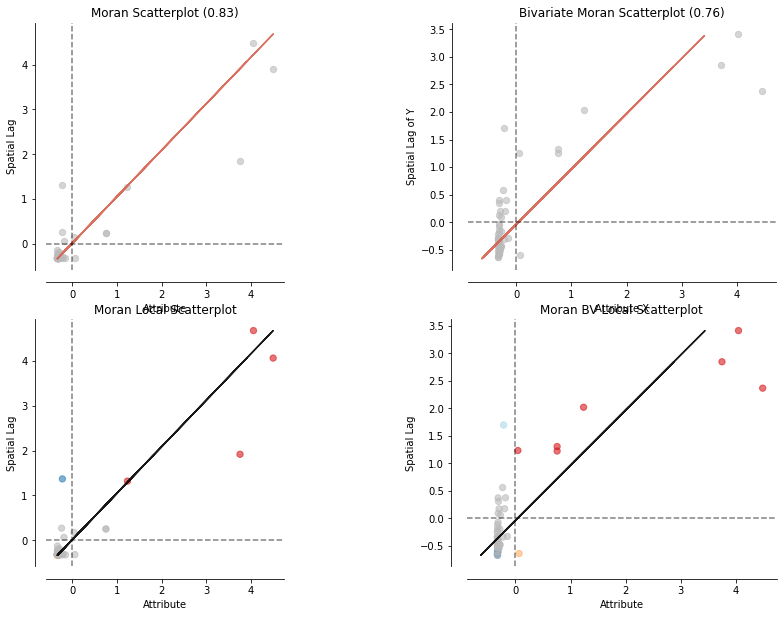

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(15,10),
                        subplot_kw={'aspect': 'equal'})

moran_scatterplot(moran, ax=axs[0,0])
moran_scatterplot(moran_loc, p=0.05, ax=axs[1,0])
moran_scatterplot(moran_bv, ax=axs[0,1])
moran_scatterplot(moran_loc_bv, p=0.05, ax=axs[1,1])
plt.show()

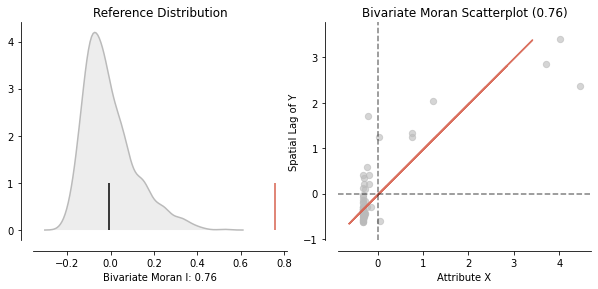

In [54]:
plot_moran_bv(moran_bv)
plt.show()

In [55]:
from esda.moran import Moran_Local_BV

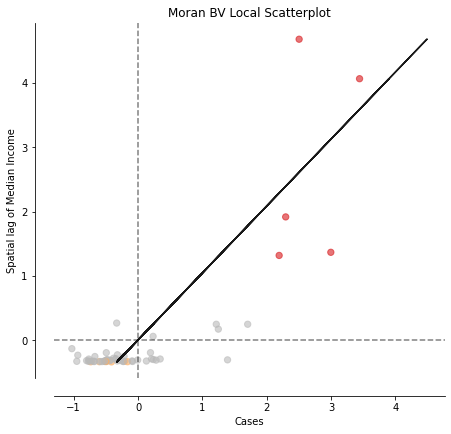

In [56]:
moran_loc_bv = Moran_Local_BV(x, y, w)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Cases')
ax.set_ylabel('Spatial lag of Median Income')
plt.show()

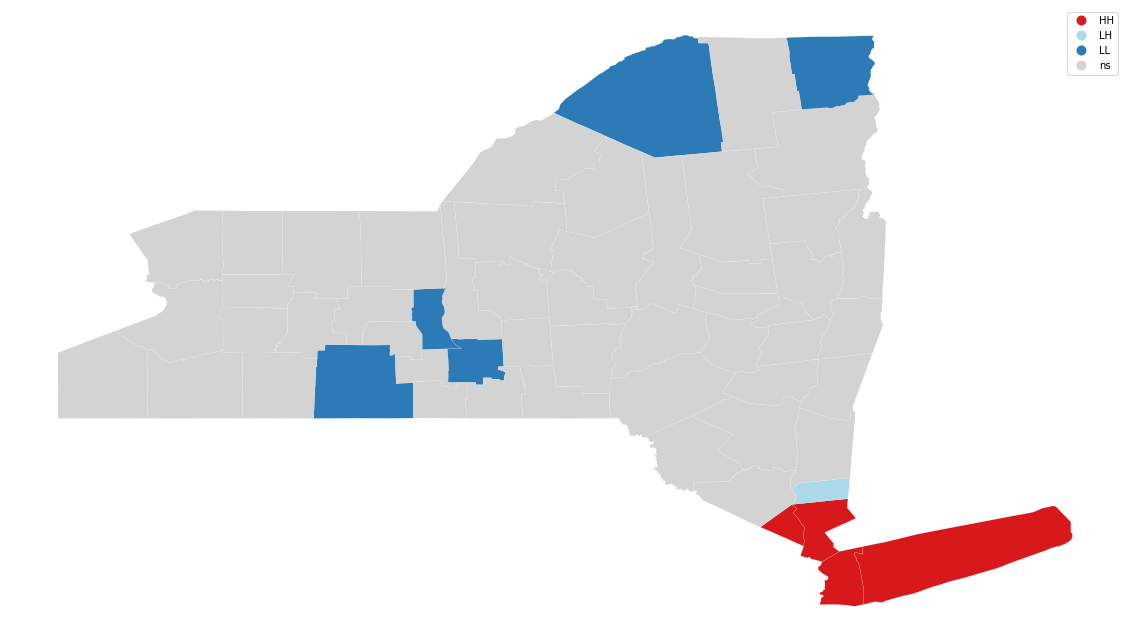

In [22]:
#Visualising the spatial clusters : HH - High-High Clustering, HL - High-Low Clustering, LL - Low-Low Clustering, ns - no clustering etc
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, sdat, p=0.05, figsize = (20,15))
plt.show()

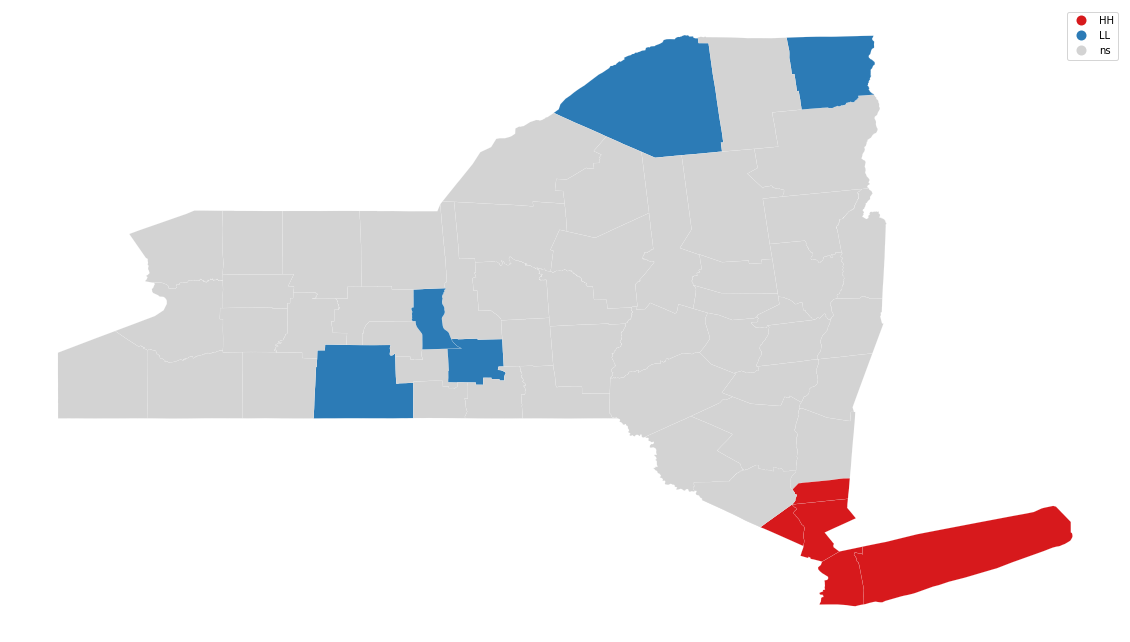

In [59]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc_bv, ddat, p=0.05, figsize = (20,15))
plt.show()

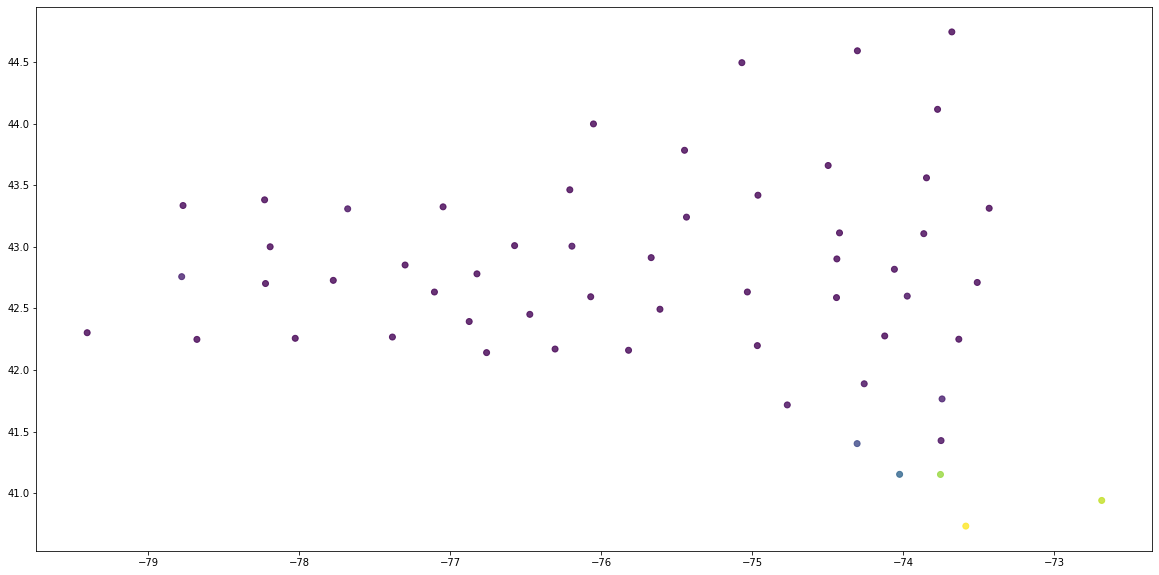

In [13]:
#Plotting centroids with magnitudes
plt.figure(figsize=(20,10))
plt.scatter(y= sdat.y, x = sdat.x , c = sdat.cases, alpha=0.8);
plt.show()

array([   6217,   11112,    1142,    1972,   35518,    4746,     234,
           898, 1038351,     143,   88841,    1996,    4846,   31733,
          1367,    3579,    1929,    4186,    1977,    2085, 1142566,
          5081,    3480,  967273,     311,    2834,     925,   93897,
         27301,    1519,   23121,    2143,   12225,    1355,     397,
          1879,   43764,    1022,    8051,    7900,     968,    4043,
          2207,   11713,    3281,    1782,    5382,    1023,     535,
         24978,    3033,    1681,  371558,    1951,    1954,  257693,
         13205])

In [14]:
#Learning spatial weights for analysing Spatial Autocorrelation amongst datapoints
y = sdat['cases'].values
w = Queen.from_dataframe(sdat)
w.transform = 'r'

In [15]:
from esda.moran import Moran

w = Queen.from_dataframe(sdat)
moran = Moran(y, w)
moran.I

0.8426779874040754

Positive Spatial Autocorrelation exists amongst counties

In [16]:
from splot.esda import moran_scatterplot

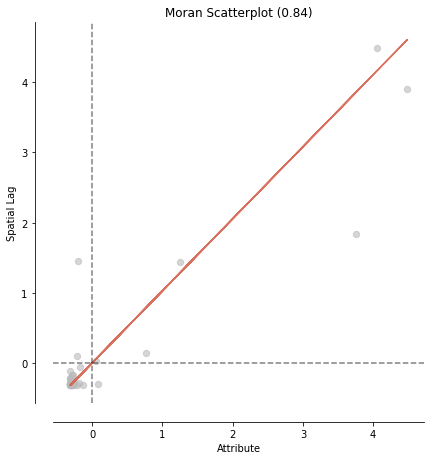

In [17]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

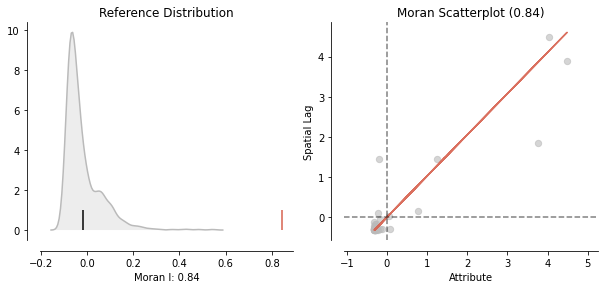

In [18]:
#Reference plots
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [19]:
#Statistical significance 
moran.p_sim

0.001

Results are statistically significant

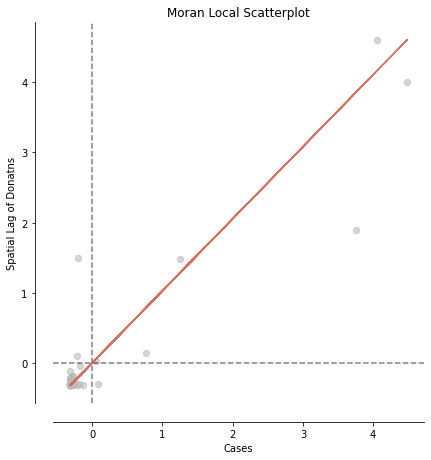

In [20]:
#Local autocorrelation and hotspot analysis
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('Cases')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

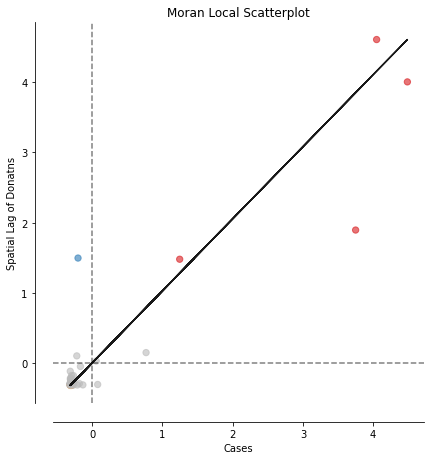

In [21]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Cases')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

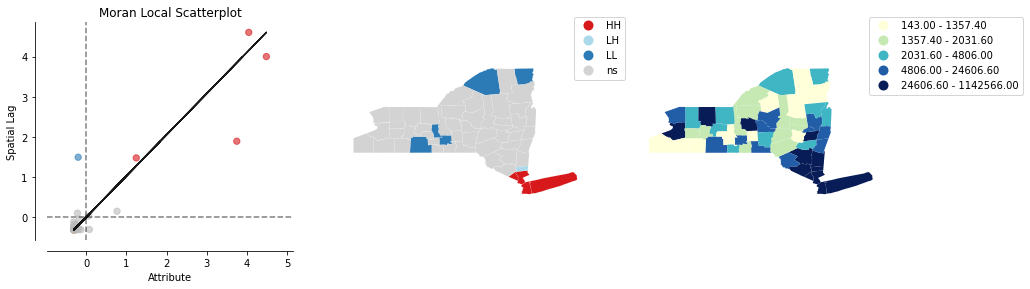

In [23]:
#All together
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, sdat,'cases')
plt.show()

In [41]:
data_ny.head()

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0
448,2020-03-02,New York City,New York,NaN,1,0
482,2020-03-03,New York City,New York,NaN,2,0
518,2020-03-04,New York City,New York,NaN,2,0
519,2020-03-04,Westchester,New York,36119.0,9,0


In [42]:
#Loading spatial data on counties acquired from the following link - https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2019&layergroup=Counties+%28and+equivalent%29
spatial_data = gpd.read_file('tl_2019_us_county.shp')
spatial_data.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


In [45]:
x=list(spatial_data.NAME.unique())
x

['Cuming',
 'Wahkiakum',
 'De Baca',
 'Lancaster',
 'Nuckolls',
 'Las Piedras',
 'Minnehaha',
 'Menard',
 'Sierra',
 'Clinton',
 'Hancock',
 'Hale',
 'Clay',
 'Armstrong',
 'Allen',
 'McDuffie',
 'Sauk',
 'Stone',
 'Wallowa',
 'Beaver',
 'Jasper',
 'Henry',
 'Saguache',
 'Chatham',
 'Rich',
 'Adair',
 'Lake',
 'Salem',
 'Montgomery',
 'Hamilton',
 'Otero',
 'Catron',
 'Marengo',
 'Lincoln',
 'Barton',
 'Calhoun',
 'Poquoson',
 'Pocahontas',
 'James City',
 'Keith',
 'Phelps',
 'Calcasieu',
 'Union',
 'Sequoyah',
 'DeKalb',
 'Steuben',
 'Forest',
 'Tangipahoa',
 'Stafford',
 'Menominee',
 'Brantley',
 'Lamar',
 'Orange',
 'Fayette',
 'Hampshire',
 'Alamance',
 'Greenwood',
 'Suffolk',
 'Jefferson',
 'Gonzales',
 'Marion',
 'Alpena',
 'Wayne',
 'White',
 'Fannin',
 'Doniphan',
 'Kerr',
 'Hernando',
 'Wakulla',
 'Walton',
 'Chickasaw',
 'Ketchikan Gateway',
 'Clare',
 'Republic',
 'Volusia',
 'Canadian',
 'Quebradillas',
 'St. Thomas',
 'Floyd',
 'Churchill',
 'Webster',
 'Hutchinson',
 '

In [ ]:
spatial[spatial_data['NAME']=='New York'